In [3]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
svo_path = '../data/VGA_SN35520970_15-39-15.svo'

In [5]:
zed = sl.Camera()

In [6]:

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [7]:
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_ACCURATE

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 10
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

In [8]:
detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

detected_objects_list = []

while zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    # Retrieve objects
    zed.retrieve_objects(detected_objects, detection_parameters_rt)

    frame_nr = zed.get_svo_position()

    for i, obj in enumerate(detected_objects.object_list):
        if obj.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
            detected_objects_list.append({
                'obj': obj,
                'obj_nr': i,
                'frame_nr': frame_nr
            })

In [9]:
df_detected_objects = pd.DataFrame(
    data=[
        [
            obj['frame_nr'],
            obj['obj_nr'],
            obj['obj'].id,
            obj['obj'].label,
            obj['obj'].confidence,
            obj['obj'].tracking_state,
            obj['obj'].position[0],
            obj['obj'].position[1],
            obj['obj'].position[2],
            obj['obj'].velocity[0],
            obj['obj'].velocity[1],
            obj['obj'].velocity[2],
            obj['obj'].dimensions[0],
            obj['obj'].dimensions[1],
            obj['obj'].dimensions[2]
        ] for obj in detected_objects_list
    ],
    columns=['frame', 'object', 'object_id', 'object_label', 'confidence', 'tracking_state', 'x', 'y', 'z', 'vx', 'xy', 'vz', 'width', 'height', 'length']
)

In [10]:
df_detected_objects

frame  object  object_id object_label  confidence tracking_state  \
0          2       0          0       Person   31.909180             OK   
1          2       1          2       Person   59.814453             OK   
2          2       2          3       Person   13.476562             OK   
3          2       3          1       Person   60.937500             OK   
4          3       0          0       Person   51.074219             OK   
...      ...     ...        ...          ...         ...            ...   
32841  11006       2        228       Person   12.683105             OK   
32842  11007       0        214       Person   69.921875             OK   
32843  11007       1        228       Person   12.683105             OK   
32844  11008       0        214       Person   66.357422             OK   
32845  11009       0        214       Person   68.261719             OK   

               x          y          z        vx        xy         vz  \
0       0.563878   0.366873   1.085193  0.111168  0.012892  -0.037131   
1      -6.588584  -9.677654  35.292397  2.054242  3.934795 -11.496395   
2      -1.682056  -9.557975  36.092300  0.087472  1.048210  -3.012980   
3       7.363783  -9.844363  36.457458  1.601340 -0.881382   2.681855   
4       0.553523   0.365007   1.086148  0.042715  0.046701  -0.111586   
...          ...        ...        ...       ...       ...        ...   
32841 -14.053241 -10.603930  38.405037 -0.976564  0.111104   0.447149   
32842   5.481584  -5.796669  23.500216 -0.655601 -0.734146   0.541135   
32843 -14.118252 -10.627138  38.423225 -0.984613 -0.596420   0.248536   
32844   5.388110  -5.793725  23.491503 -0.798097  0.113523   0.680610   
32845   5.289842  -5.801022  23.525934       NaN       NaN        NaN   

          width    height    length  
0      0.501725  0.112318  0.501725  
1      1.073330  2.140135  1.073331  
2      0.875707  1.050539  0.875710  
3      0.868947  2.499477  0.868952  
4      0.502330  0.118132  0.502330  
...         ...       ...       ...  
32841  0.980982  1.830289  0.980981  
32842  0.755342  2.173084  0.755341  
32843  0.971260  1.830401  0.971258  
32844  0.748495  2.173220  0.748492  
32845  0.767303  2.168923  0.767304  

[32846 rows x 15 columns]

In [56]:
df_detected_objects['object_label'].value_counts()

object_label
Person    32118
Sport       727
Name: count, dtype: int64

In [64]:
ballframes = df_detected_objects[df_detected_objects['object_label'] == 'Sport']

In [65]:
ballframes

Empty DataFrame
Columns: [frame, object, object_id, object_label, confidence, tracking_state, x, y, z, vx, xy, vz, width, height, length]
Index: []

In [85]:
zed.set_svo_position(737)
zed.grab()
image_left = sl.Mat()
zed.retrieve_image(image_left, sl.VIEW.LEFT)

SUCCESS

In [86]:
image_left.get_data().shape

(376, 672, 4)

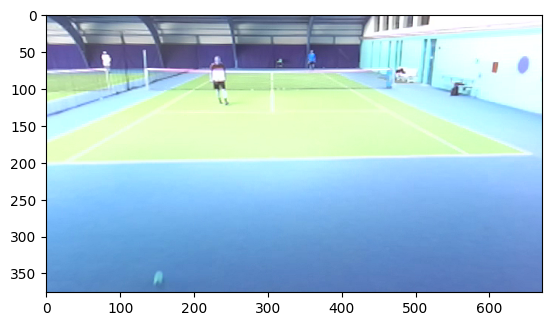

In [87]:
plt.imshow(image_left.get_data())

In [79]:
def main():
    # Create a ZED camera object
    zed = sl.Camera()

    # Set configuration parameters
    init_params = sl.InitParameters()
    init_params.set_from_svo_file('../data/VGA_SN35520970_15-39-15.svo')

    # Open the camera
    err = zed.open(init_params)
    if err != sl.ERROR_CODE.SUCCESS:
        print(repr(err))
        exit(-1)

    # Loop between frames 0 and 50
    left_image = sl.Mat()
    while zed.get_svo_position() < zed.get_svo_number_of_frames() - 1:

        print("Current frame: ", zed.get_svo_position())

        # Loop if we reached frame 50
        if zed.get_svo_position() == 50:
            zed.set_svo_position(0)

        # Grab an image
        if zed.grab() == sl.ERROR_CODE.SUCCESS:
            zed.retrieve_image(left_image, sl.VIEW.LEFT) # Get the rectified left image

        # Use the image in your application
        plt.imshow(left_image.get_data())
        plt.show()
    # Close the Camera
    zed.close()
    return 0

Current frame:  0


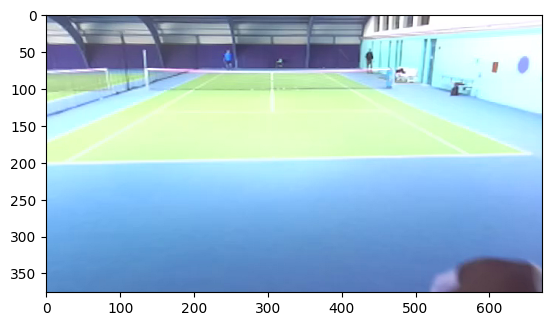

Current frame:  0


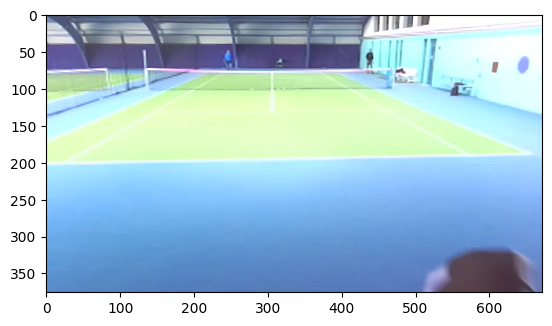

Current frame:  1


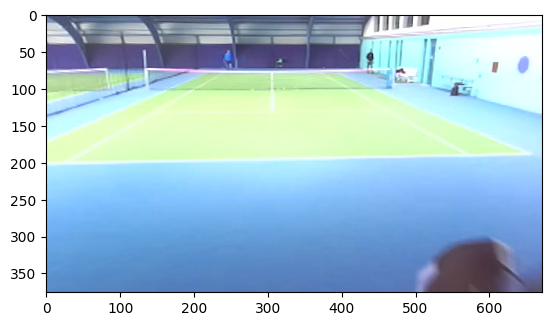

Current frame:  2


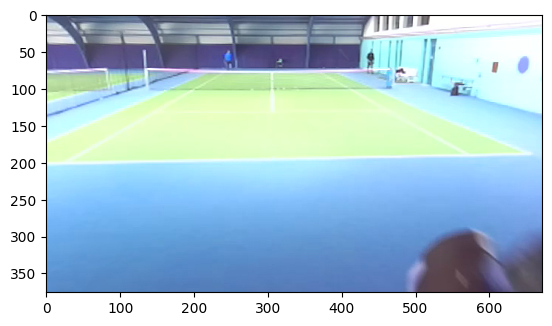

Current frame:  3


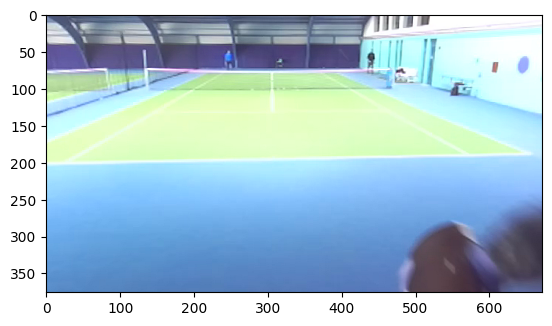

Current frame:  4


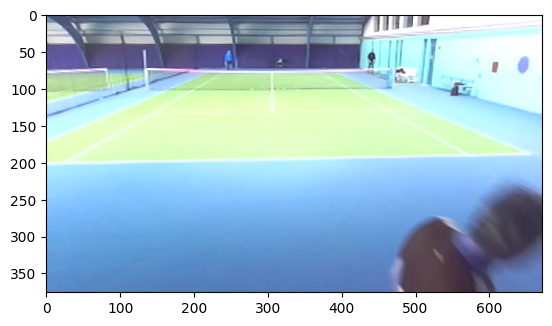

Current frame:  5


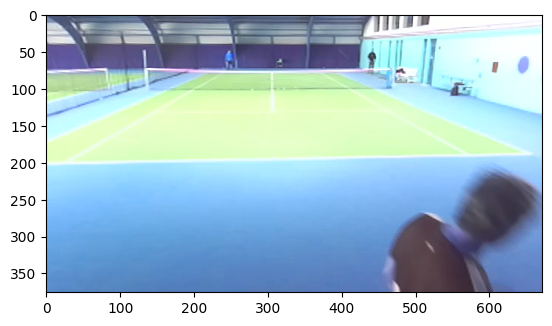

Current frame:  6


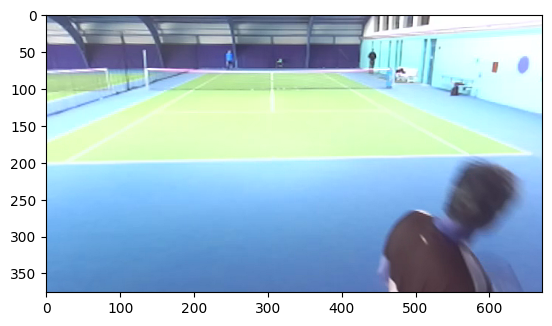

Current frame:  7


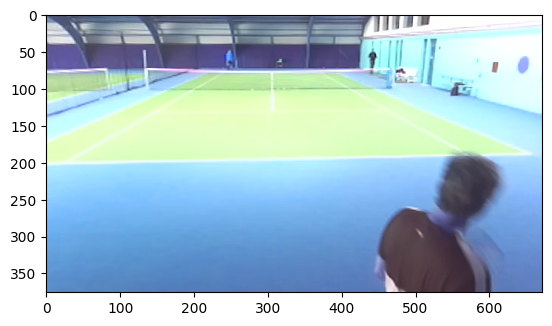

Current frame:  8


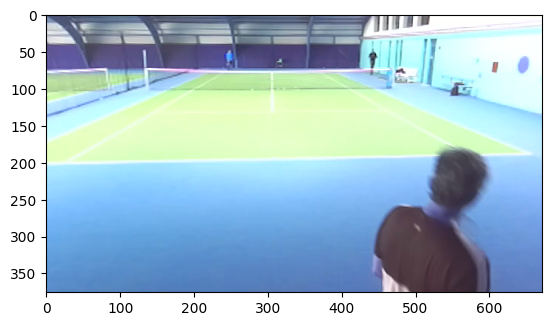

Current frame:  9


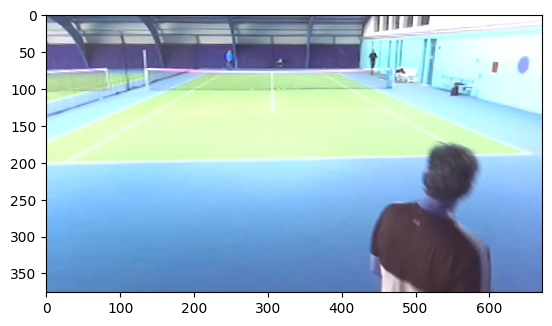

Current frame:  10


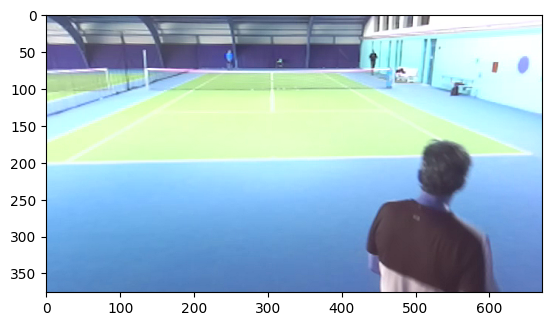

Current frame:  11


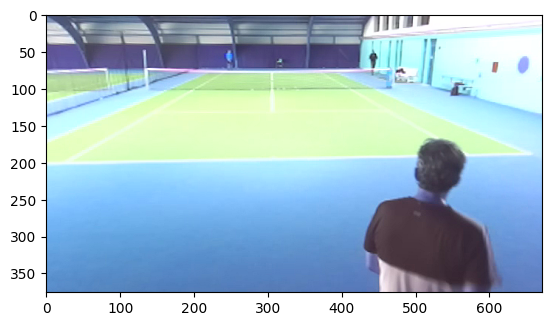

Current frame:  12


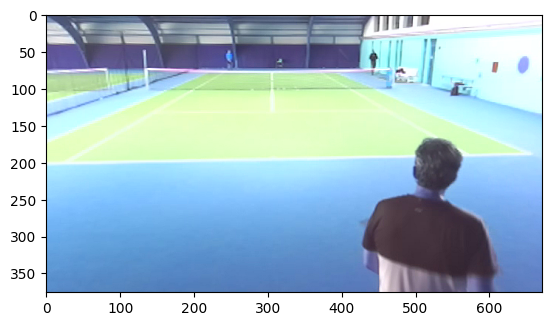

Current frame:  13


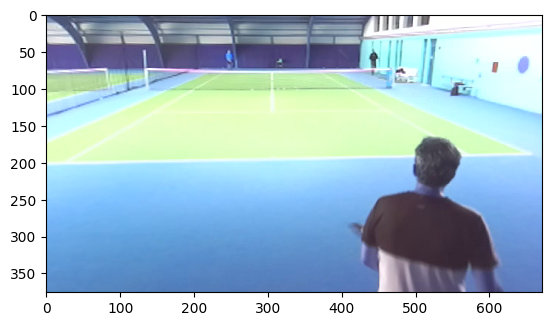

Current frame:  14


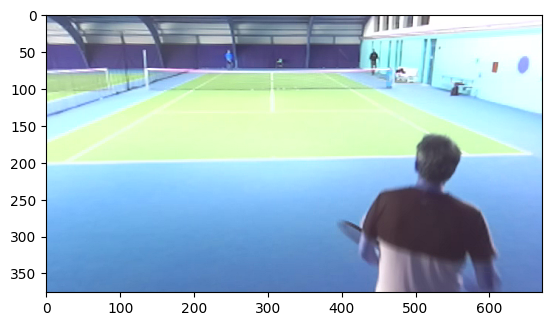

Current frame:  15


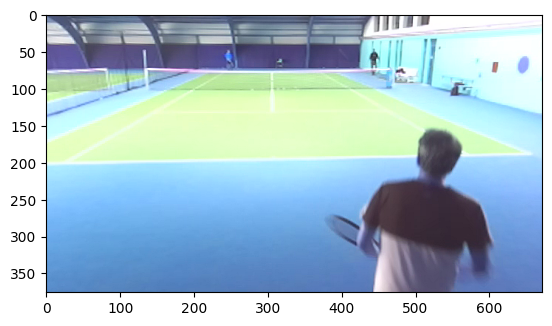

Current frame:  16


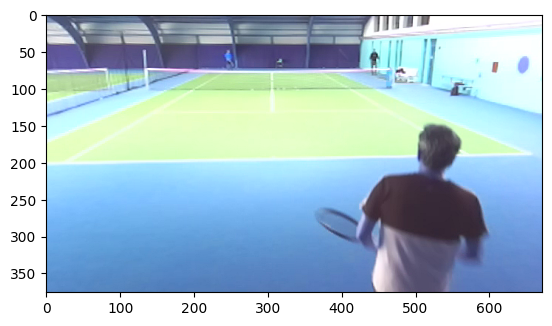

Current frame:  17


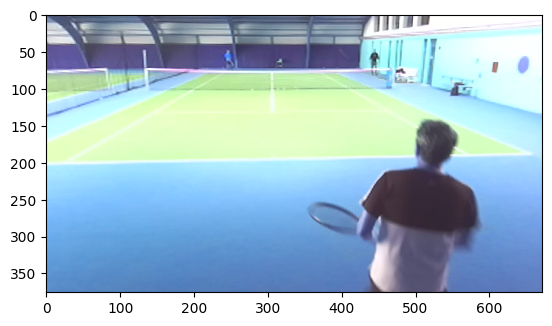

Current frame:  18


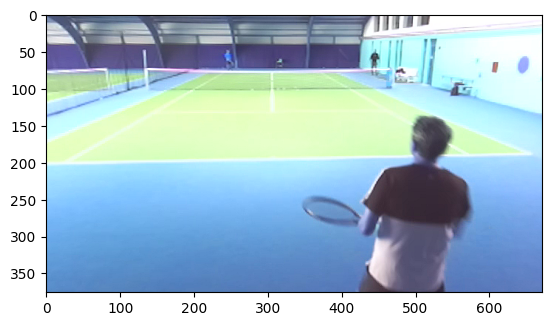

Current frame:  19


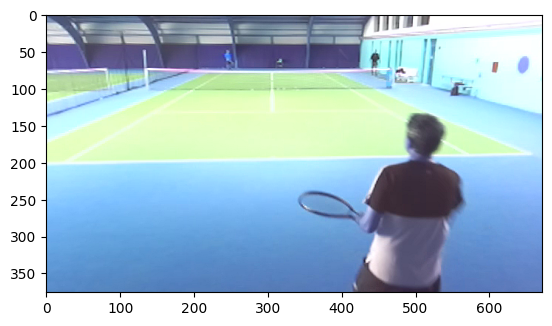

Current frame:  20


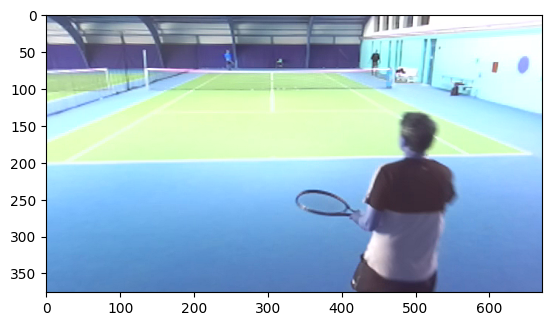

Current frame:  21


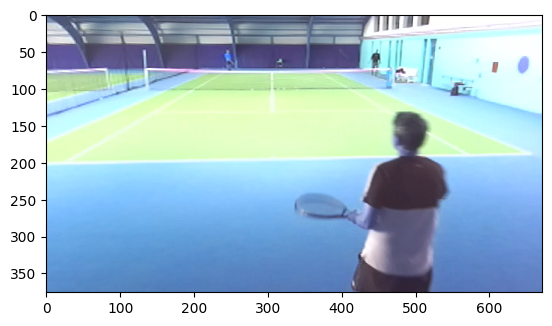

Current frame:  22


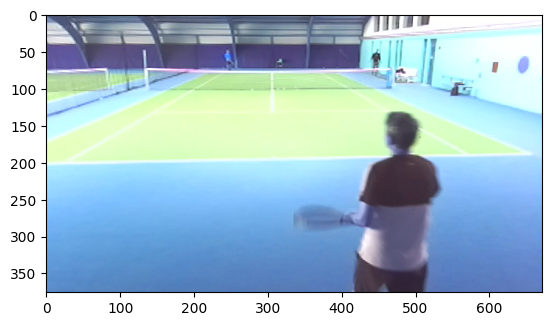

Current frame:  23


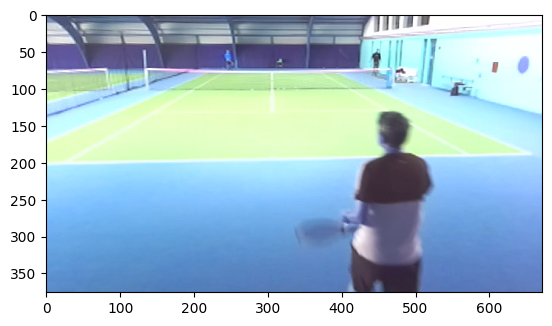

Current frame:  24


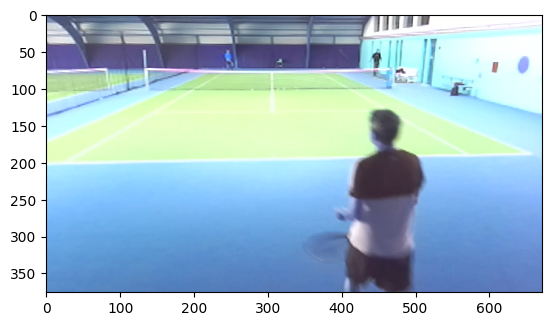

Current frame:  25


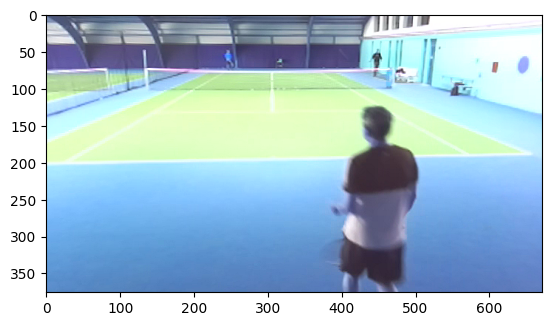

Current frame:  26


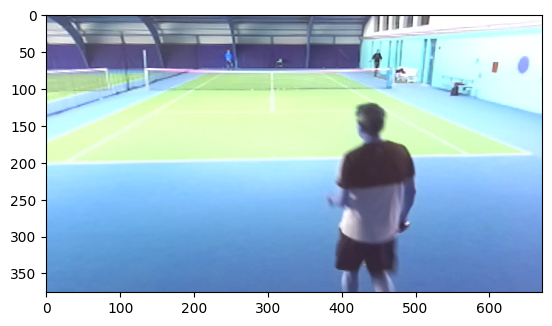

Current frame:  27


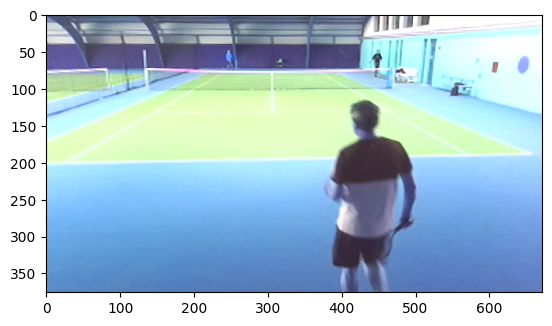

Current frame:  28


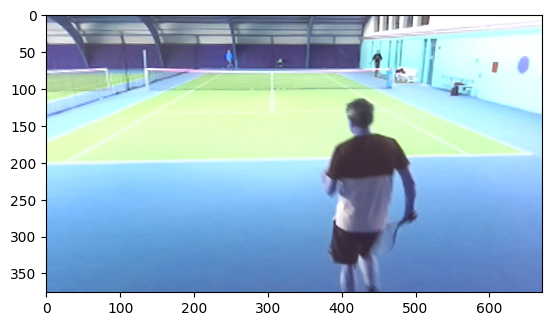

Current frame:  29


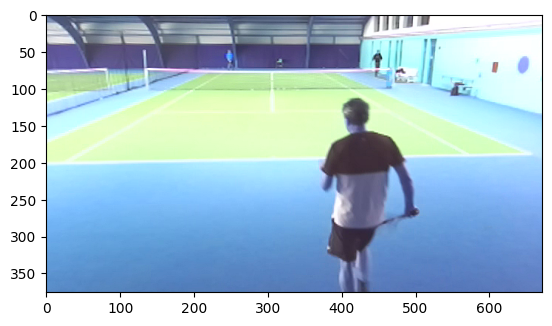

Current frame:  30


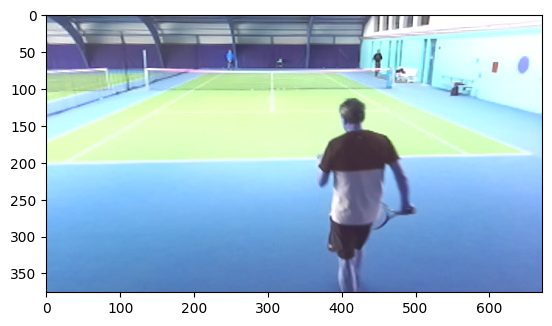

Current frame:  31


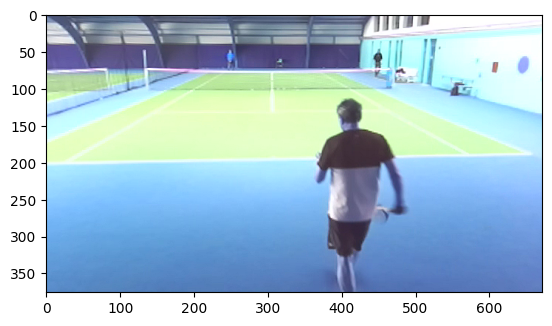

Current frame:  32


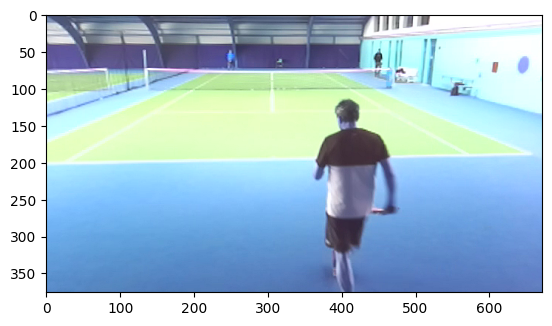

Current frame:  33


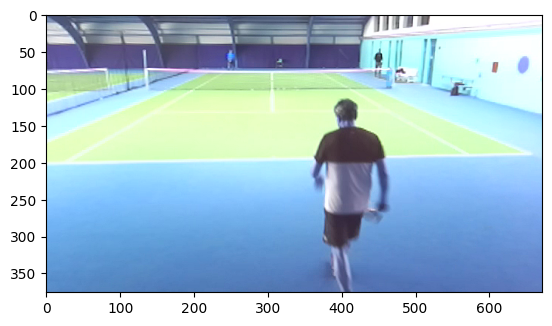

Current frame:  34


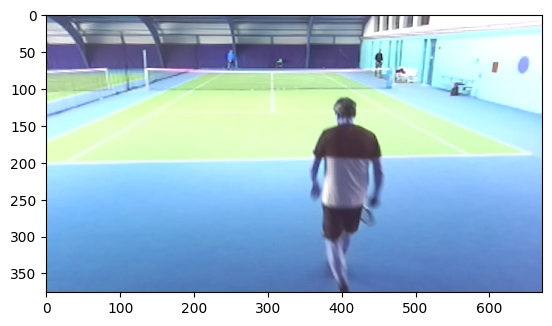

Current frame:  35


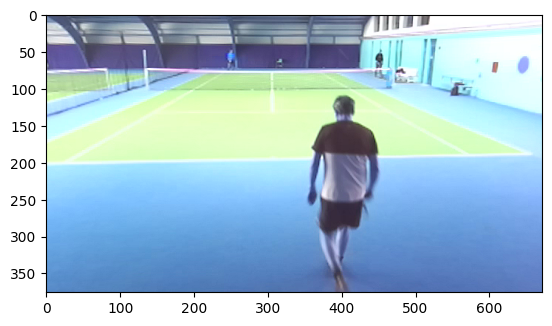

Current frame:  36


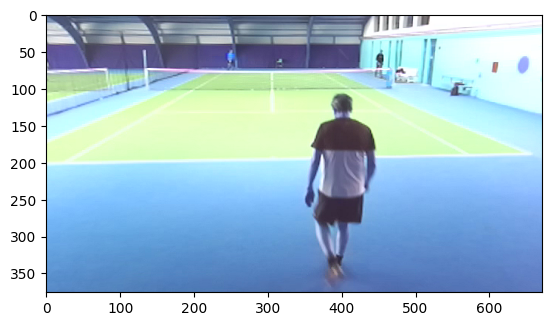

Current frame:  37


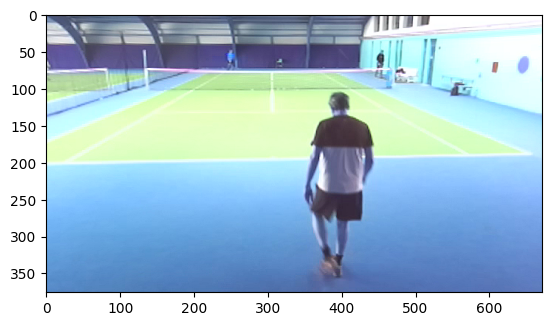

Current frame:  38


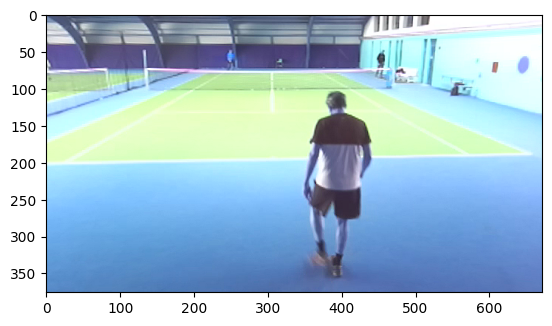

Current frame:  39


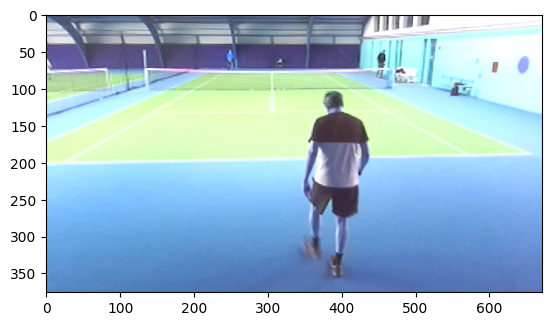

Current frame:  40


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [80]:
main()